# 🤖 Transformers: DistilBERT para Detección de Hate Speech

## Objetivos:
1. Entrenar modelo DistilBERT (Nivel Experto)
2. Comparar con modelo clásico (SVM optimizado)
3. Evaluar métricas y overfitting
4. Decidir si usar DistilBERT en producción


## 1. Importar librerías


In [3]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
import pickle
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from models.transformers import (
    train_distilbert,
    evaluate_distilbert,
    save_distilbert_model,
    load_distilbert_model,
    predict_distilbert
)
from models.train import load_model
from models.evaluate import evaluate_model
from features.vectorization import load_vectorized_data, split_train_test
import torch

print("✅ Librerías importadas")


✅ Librerías importadas


## 2. Cargar datos


In [4]:
# Cargar datos preprocesados
df = pd.read_csv('../data/processed/youtoxic_english_1000_processed.csv')

# Convertir IsToxic a numérico (True/False -> 1/0)
# También convertir si viene como string 'TRUE'/'FALSE'
if df['IsToxic'].dtype == object:
    df['Label'] = df['IsToxic'].map({'TRUE': 1, 'FALSE': 0, True: 1, False: 0, 'True': 1, 'False': 0})
else:
    df['Label'] = df['IsToxic'].astype(int)

# Dividir en train/test (mismo split que modelos clásicos)
X_train, X_test, y_train, y_test = split_train_test(
    df,
    text_column='Text_processed',
    label_column='Label',
    test_size=0.2,
    random_state=42
)

print(f"✅ Datos cargados:")
print(f"   Train: {len(X_train)} ejemplos")
print(f"   Test: {len(X_test)} ejemplos")
print(f"   Distribución train: {y_train.value_counts().to_dict()}")
print(f"   Distribución test: {y_test.value_counts().to_dict()}")


✅ División train/test completada:
   Train: 800 ejemplos (80.0%)
   Test: 200 ejemplos (20.0%)
   Distribución train: {0: 430, 1: 370}
   Distribución test: {0: 108, 1: 92}
✅ Datos cargados:
   Train: 800 ejemplos
   Test: 200 ejemplos
   Distribución train: {0: 430, 1: 370}
   Distribución test: {0: 108, 1: 92}


## 3. Entrenar DistilBERT


In [5]:
# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Dispositivo: {device}")

# Entrenar DistilBERT
model_distilbert, metrics_distilbert = train_distilbert(
    X_train,
    y_train,
    X_test,
    y_test,
    model_name='distilbert-base-uncased',
    num_epochs=5,
    batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_path=Path('../models/transformers/distilbert_model'),
    verbose=True
)

print(f"\n📊 Métricas DistilBERT (Test):")
print(f"   F1-score: {metrics_distilbert['f1']:.4f}")
print(f"   Accuracy: {metrics_distilbert['accuracy']:.4f}")
print(f"   Precision: {metrics_distilbert['precision']:.4f}")
print(f"   Recall: {metrics_distilbert['recall']:.4f}")


🔧 Dispositivo: cpu
🔧 Entrenando DistilBERT
   Dispositivo: cpu
   Modelo: distilbert-base-uncased
   Épocas: 5
   Batch size: 16
   Learning rate: 2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Época 1/5:
   Loss: 0.6921
   Test F1: 0.2308
   Test Accuracy: 0.6000

Época 2/5:
   Loss: 0.6335
   Test F1: 0.6897
   Test Accuracy: 0.7300

Época 3/5:
   Loss: 0.4452
   Test F1: 0.7337
   Test Accuracy: 0.7350

Época 4/5:
   Loss: 0.2785
   Test F1: 0.7143
   Test Accuracy: 0.7600

Época 5/5:
   Loss: 0.1708
   Test F1: 0.7176
   Test Accuracy: 0.7600

⏹️  Early stopping en época 5
✅ Modelo y tokenizador guardados en: ../models/transformers/distilbert_model

✅ Modelo guardado en: ../models/transformers/distilbert_model

📊 Métricas DistilBERT (Test):
   F1-score: 0.7176
   Accuracy: 0.7600
   Precision: 0.7821
   Recall: 0.6630


## 4. Cargar modelo clásico (SVM optimizado) para comparar


In [11]:
# Cargar datos vectorizados y modelo SVM optimizado
X_train_vec, X_test_vec, y_train_vec, y_test_vec = load_vectorized_data(
    Path('../data/processed'),
    prefix='tfidf'
)

model_svm = load_model(Path('../models/optimized/best_optimized_model.pkl'))

# Evaluar SVM
metrics_svm = evaluate_model(
    model_svm,
    X_train_vec,
    X_test_vec,
    y_train_vec,
    y_test_vec,
    verbose=False
)

print(f"📊 Métricas SVM Optimizado:")
print(f"   F1-score (test): {metrics_svm['test_f1']:.4f}")
print(f"   F1-score (train): {metrics_svm['train_f1']:.4f}")
print(f"   Overfitting: {metrics_svm['diff_f1']:.2f}%")
print(f"   Accuracy (test): {metrics_svm['test_accuracy']:.4f}")


✅ Datos vectorizados cargados desde: ../data/processed
✅ Modelo cargado desde: ../models/optimized/best_optimized_model.pkl
📊 Métricas SVM Optimizado:
   F1-score (test): 0.6866
   F1-score (train): 0.7119
   Overfitting: 2.54%
   Accuracy (test): 0.5800


## 5. Comparación de Modelos


In [9]:
# Crear DataFrame comparativo
comparison_data = {
    'Modelo': ['SVM Optimizado', 'DistilBERT'],
    'F1-score (test)': [metrics_svm['test_f1'], metrics_distilbert['f1']],
    'Accuracy (test)': [metrics_svm['test_accuracy'], metrics_distilbert['accuracy']],
    'Precision (test)': [metrics_svm['test_precision'], metrics_distilbert['precision']],
    'Recall (test)': [metrics_svm['test_recall'], metrics_distilbert['recall']],
    'Overfitting (%)': [metrics_svm['diff_f1'], 'N/A']  # DistilBERT no tiene train/test split interno
}

df_comparison = pd.DataFrame(comparison_data)
print("="*80)
print("COMPARACIÓN DE MODELOS")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Determinar mejor modelo
if metrics_distilbert['f1'] > metrics_svm['test_f1']:
    print(f"\n🏆 DistilBERT es mejor (F1: {metrics_distilbert['f1']:.4f} vs {metrics_svm['test_f1']:.4f})")
    best_model = 'DistilBERT'
else:
    print(f"\n🏆 SVM Optimizado es mejor (F1: {metrics_svm['test_f1']:.4f} vs {metrics_distilbert['f1']:.4f})")
    best_model = 'SVM Optimizado'


COMPARACIÓN DE MODELOS
        Modelo  F1-score (test)  Accuracy (test)  Precision (test)  Recall (test) Overfitting (%)
SVM Optimizado         0.686567             0.58          0.522727       1.000000          2.5363
    DistilBERT         0.717647             0.76          0.782051       0.663043             N/A

🏆 DistilBERT es mejor (F1: 0.7176 vs 0.6866)


## 6. Visualización Comparativa


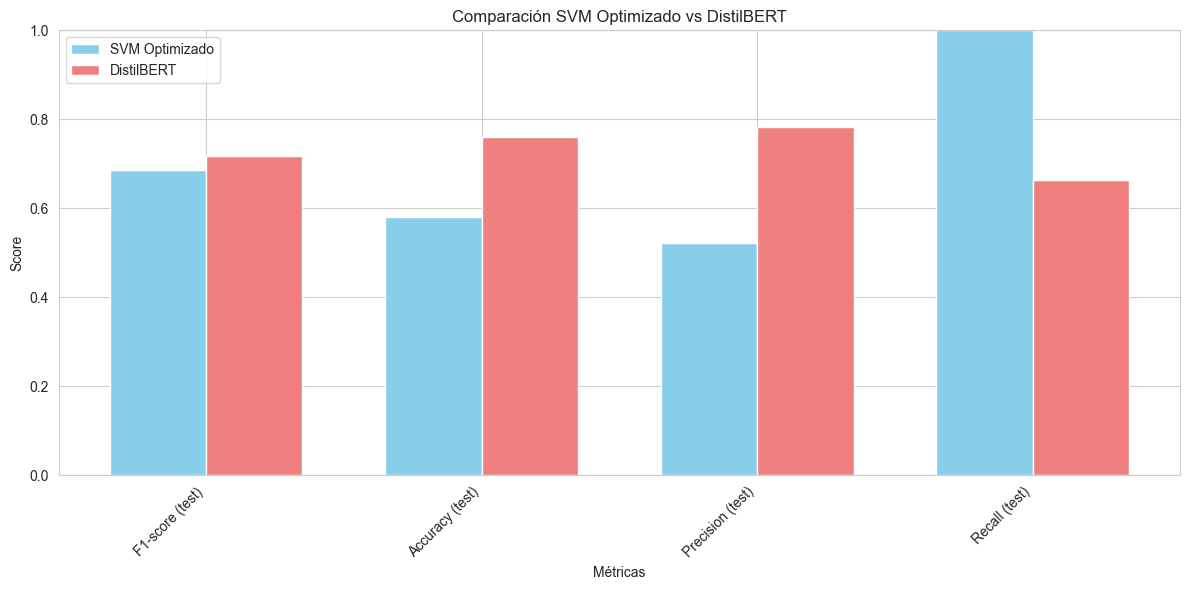

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Gráfico de barras comparativo
metrics_to_compare = ['F1-score (test)', 'Accuracy (test)', 'Precision (test)', 'Recall (test)']
x = np.arange(len(metrics_to_compare))
width = 0.35

svm_values = [
    metrics_svm['test_f1'],
    metrics_svm['test_accuracy'],
    metrics_svm['test_precision'],
    metrics_svm['test_recall']
]

distilbert_values = [
    metrics_distilbert['f1'],
    metrics_distilbert['accuracy'],
    metrics_distilbert['precision'],
    metrics_distilbert['recall']
]

plt.bar(x - width/2, svm_values, width, label='SVM Optimizado', color='skyblue')
plt.bar(x + width/2, distilbert_values, width, label='DistilBERT', color='lightcoral')

plt.xlabel('Métricas')
plt.ylabel('Score')
plt.title('Comparación SVM Optimizado vs DistilBERT')
plt.xticks(x, metrics_to_compare, rotation=45, ha='right')
plt.legend()
plt.ylim([0, 1])
plt.tight_layout()
plt.show()
